## Import Data ##

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import numpy as np
import networkx as nx
import random
from scipy.stats import *
import time
import warnings
import os

warnings.filterwarnings("ignore", category=DeprecationWarning)

device = "mps" if torch.mps.is_available() else "cpu"
print(device)

mps


In [12]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root="/tmp/PubMed", name="PubMed")
data = dataset[0]

## Statistical Modeling ##

In [14]:
pd_data = pd.DataFrame(data.x.cpu().numpy())

In [16]:
pd_data.shape

(19717, 500)

In [18]:
pd_data.corr()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,-0.062658,-0.040544,0.049495,0.000926,-0.041236,-0.033465,-0.035877,0.209554,0.046704,...,0.109917,0.023323,0.031634,-0.034599,-0.031804,-0.031612,-0.024034,0.018707,0.018592,-0.041649
1,-0.062658,1.000000,0.031821,-0.004482,0.020897,-0.000913,-0.009302,0.035769,-0.026572,-0.007611,...,-0.021174,-0.015215,-0.012109,-0.000297,-0.001176,0.033943,-0.013382,-0.005701,0.016705,0.084830
2,-0.040544,0.031821,1.000000,0.018856,-0.017353,-0.009249,0.028727,0.079145,-0.001080,0.109514,...,-0.015483,-0.032164,0.001119,0.011508,-0.016020,0.033615,0.003644,0.003333,0.009205,-0.013760
3,0.049495,-0.004482,0.018856,1.000000,0.012843,0.073100,-0.009387,0.032419,0.012652,0.005312,...,0.014180,0.013159,-0.007529,-0.016498,-0.019557,-0.014342,-0.012012,0.021385,0.017954,-0.006480
4,0.000926,0.020897,-0.017353,0.012843,1.000000,0.012435,0.054767,0.002528,0.043723,0.073775,...,0.002864,0.023142,-0.013061,-0.019685,-0.002005,0.009707,0.067830,-0.023259,-0.000600,-0.002145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,-0.031612,0.033943,0.033615,-0.014342,0.009707,-0.021875,0.052234,0.005134,-0.021866,0.051499,...,-0.021098,-0.021351,-0.016216,-0.016399,-0.009960,1.000000,0.003137,-0.011821,-0.012953,0.030831
496,-0.024034,-0.013382,0.003644,-0.012012,0.067830,-0.019097,0.080367,-0.025911,-0.010397,0.025110,...,-0.017343,-0.017870,-0.014547,-0.013453,-0.001091,0.003137,1.000000,-0.008047,0.015005,-0.003935
497,0.018707,-0.005701,0.003333,0.021385,-0.023259,-0.010204,-0.022128,0.034050,0.011732,0.006821,...,-0.009336,-0.015778,0.020230,-0.014611,-0.007563,-0.011821,-0.008047,1.000000,-0.008531,-0.011855
498,0.018592,0.016705,0.009205,0.017954,-0.000600,-0.012088,0.012691,-0.003019,0.023767,0.014675,...,-0.012300,0.019440,-0.010990,-0.011189,-0.002605,-0.012953,0.015005,-0.008531,1.000000,-0.011270


In [20]:
pd_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
count,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,...,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000,19717.000000
mean,0.017480,0.003148,0.006656,0.004452,0.002776,0.004909,0.003443,0.006161,0.006266,0.005509,...,0.003380,0.002611,0.002057,0.002006,0.002340,0.002398,0.003252,0.003104,0.002743,0.004246
std,0.044375,0.012923,0.012300,0.011207,0.012372,0.028994,0.018486,0.007580,0.022451,0.017386,...,0.021012,0.016902,0.016074,0.016942,0.025909,0.017069,0.028110,0.025147,0.029023,0.033432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004724,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.010780,0.000000,0.000000,0.000000,0.000000,0.009362,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.472358,0.280607,0.194042,0.170504,0.205859,0.641637,0.425558,0.093625,0.360806,0.501531,...,0.483434,0.520259,0.373424,0.521411,0.799442,0.397971,0.629848,0.514201,0.897279,0.892858


In [22]:
def data_to_nx_subgraph(data):
    G = nx.Graph()

    G.add_nodes_from(range(data.num_nodes))

    edge_index = data.edge_index
    edges = edge_index.t().tolist()

    G.add_edges_from(edges)

    return G

G = data_to_nx_subgraph(data)

In [24]:
nx.cluster.average_clustering(G)

0.060175209437523615

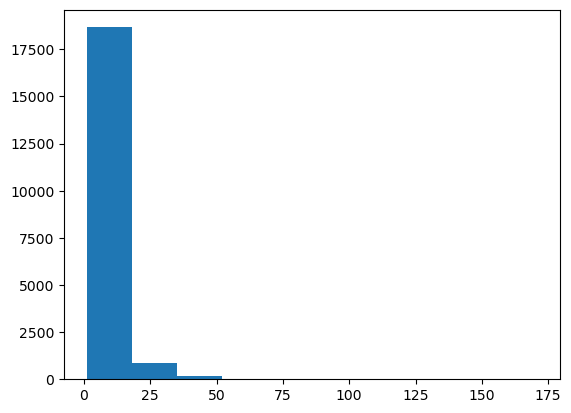

In [26]:
plt.hist([v for k, v in nx.degree(G)]);

## Training Model ##

In [32]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x

In [34]:
LR = 1e-04
HIDDEN = 32
EPOCHS = 200

In [36]:
model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes)
optimizer = Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

In [38]:
summary(model)

Layer (type:depth-idx)                   Param #
GCN                                      --
├─GCNConv: 1-1                           32
│    └─SumAggregation: 2-1               --
│    └─Linear: 2-2                       16,000
├─GCNConv: 1-2                           3
│    └─SumAggregation: 2-3               --
│    └─Linear: 2-4                       96
Total params: 16,131
Trainable params: 16,131
Non-trainable params: 0

In [40]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)
        test_accuracy = (pred[data.test_mask] == data.y[data.test_mask]).sum() / data.test_mask.sum()
        return test_accuracy.item()

In [42]:
start_time = time.time()

for epoch in range(EPOCHS):
    loss = train()
    if epoch % 10 == 0:
        test_acc = test()
        print(f'Epoch: {epoch}, Loss: {loss:.4f}, Test Accuracy: {test_acc:.4f}')

print("\nTraining Time is: ", round((time.time() - start_time), 4), " Seconds")

Epoch: 0, Loss: 1.0997, Test Accuracy: 0.2390
Epoch: 10, Loss: 1.0970, Test Accuracy: 0.3570
Epoch: 20, Loss: 1.0943, Test Accuracy: 0.4570
Epoch: 30, Loss: 1.0914, Test Accuracy: 0.5210
Epoch: 40, Loss: 1.0883, Test Accuracy: 0.5660
Epoch: 50, Loss: 1.0850, Test Accuracy: 0.5960
Epoch: 60, Loss: 1.0816, Test Accuracy: 0.6280
Epoch: 70, Loss: 1.0779, Test Accuracy: 0.6460
Epoch: 80, Loss: 1.0741, Test Accuracy: 0.6640
Epoch: 90, Loss: 1.0701, Test Accuracy: 0.6750
Epoch: 100, Loss: 1.0661, Test Accuracy: 0.6770
Epoch: 110, Loss: 1.0621, Test Accuracy: 0.6860
Epoch: 120, Loss: 1.0580, Test Accuracy: 0.6910
Epoch: 130, Loss: 1.0539, Test Accuracy: 0.6960
Epoch: 140, Loss: 1.0497, Test Accuracy: 0.6990
Epoch: 150, Loss: 1.0455, Test Accuracy: 0.6980
Epoch: 160, Loss: 1.0412, Test Accuracy: 0.6990
Epoch: 170, Loss: 1.0368, Test Accuracy: 0.7020
Epoch: 180, Loss: 1.0323, Test Accuracy: 0.7060
Epoch: 190, Loss: 1.0278, Test Accuracy: 0.7130

Training Time is:  2.4549  Seconds


## Post-Training Analysis ##

In [44]:
embeddings = []

def hook(module, input, output):
    embeddings.append(output.detach().cpu())

model.conv2.register_forward_hook(hook)

model.eval()
out = model(data.x, data.edge_index)

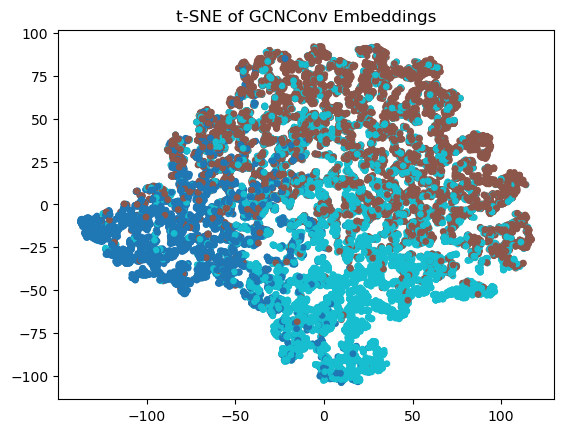

In [46]:
z = TSNE(n_components=2).fit_transform(embeddings[0].numpy())
plt.scatter(z[:, 0], z[:, 1], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

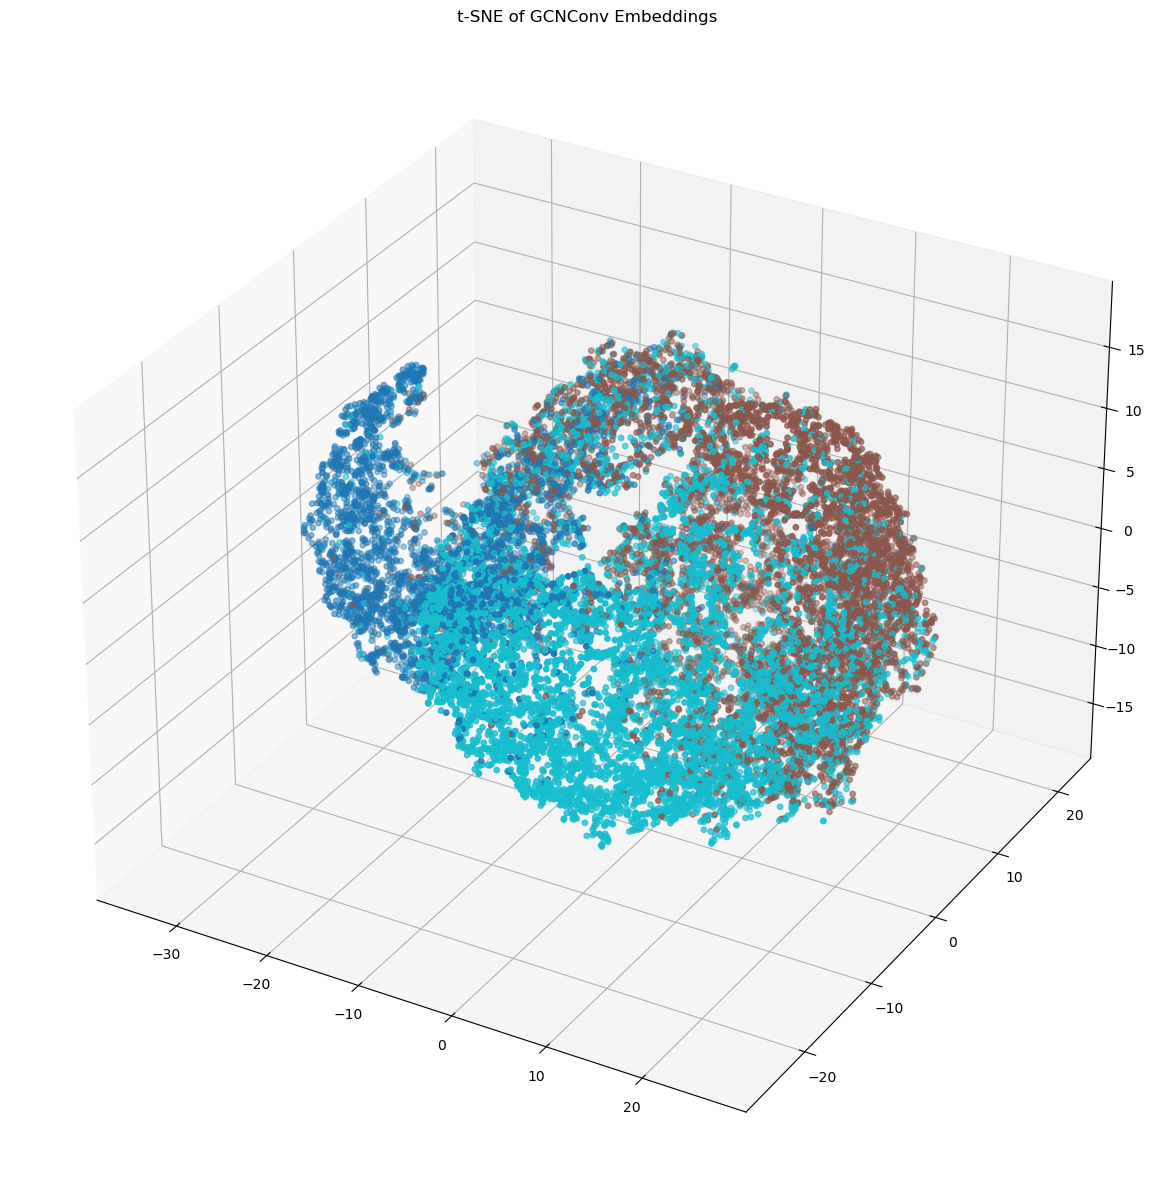

In [48]:
z = TSNE(n_components=3).fit_transform(embeddings[0].numpy())

fig = plt.figure(figsize = (15, 15))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=data.y.cpu(), cmap="tab10", s=15)
plt.title("t-SNE of GCNConv Embeddings")
plt.show()

In [50]:
probs = F.softmax(out, dim=1)
confidence, pred_class = probs.max(dim=1)

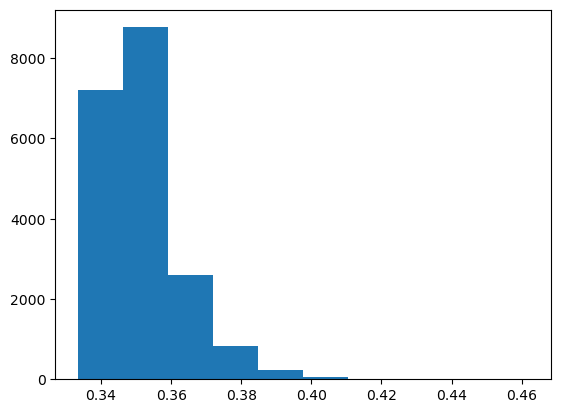

In [52]:
plt.hist(confidence.detach().numpy())
plt.show()

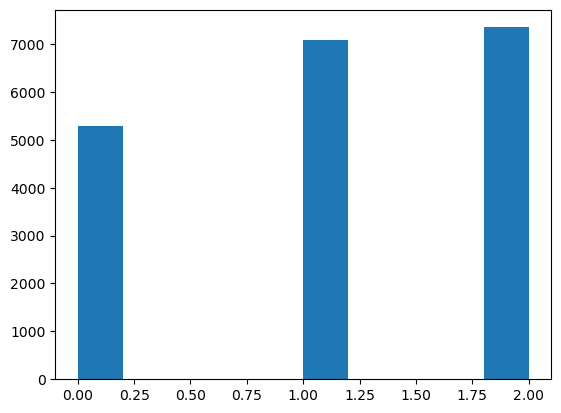

In [54]:
plt.hist(pred_class)
plt.show()

In [56]:
wrong = (pred_class != data.y).cpu()
wrong_nodes = torch.nonzero(wrong).flatten()

print(f"Number of Misclassified Nodes: {len(wrong_nodes.tolist())}")

Number of Misclassified Nodes: 5612


In [58]:
torch.save(model.state_dict(), "PubMed.pth")

In [62]:
loaded_model = GCN(in_channels=dataset.num_node_features, hidden_channels=HIDDEN, out_channels=dataset.num_classes).to(device)
loaded_model.load_state_dict(torch.load("PubMed.pth"))
loaded_model.eval()

GCN(
  (conv1): GCNConv(500, 32)
  (conv2): GCNConv(32, 3)
)